<a href="https://colab.research.google.com/github/faizankshaikh/CompBattle/blob/main/experiments/trial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install -q gymnasium pettingzoo tianshou
# !git clone https://github.com/faizankshaikh/CompBattle.git
%cd CompBattle

/content/CompBattle


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from comp.envs.comp_v0 import Comp

from torch.optim import Adam

from tianshou.data import Batch
from tianshou.utils.net.common import Net
from tianshou.trainer import offpolicy_trainer
from tianshou.data import Collector, VectorReplayBuffer
from tianshou.env import DummyVectorEnv, PettingZooEnv
from tianshou.policy import BasePolicy, DQNPolicy, MultiAgentPolicyManager

from pettingzoo.utils import parallel_to_aec

In [3]:
env = Comp()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Score [player1, player2]:[-232 -239]


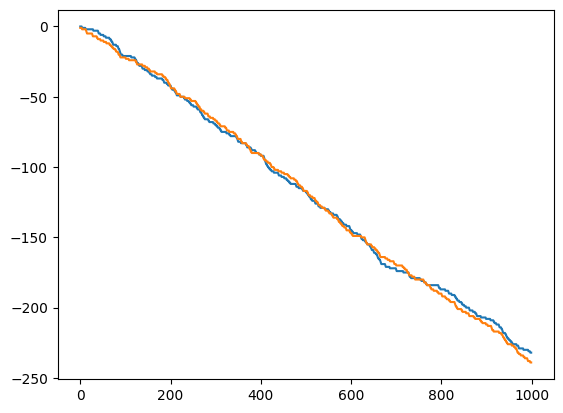

In [4]:
# both always cooperate
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": 1
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
print(f"Score [player1, player2]:{np.sum(arr, axis=0)}")
plt.plot(arr.cumsum(axis=0))
plt.show()

Score [player1, player2]:[-679 -668]


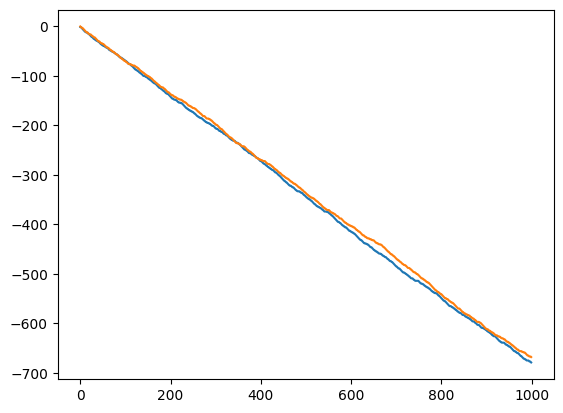

In [5]:
# both always defect
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
print(f"Score [player1, player2]:{np.sum(arr, axis=0)}")
plt.plot(arr.cumsum(axis=0))
plt.show()

Score [player1, player2]:[ -99 -687]


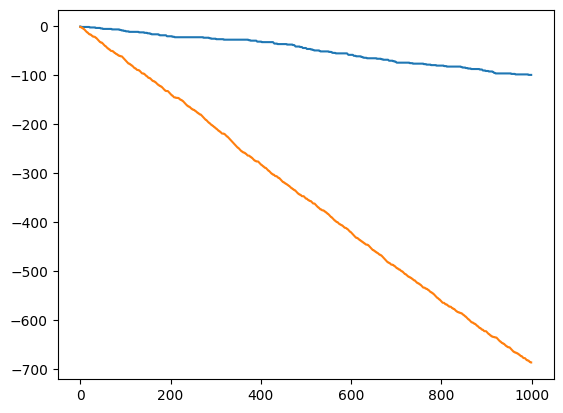

In [6]:
# player1 defects, player2 cooperates
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": 1
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
print(f"Score [player1, player2]:{np.sum(arr, axis=0)}")
plt.plot(arr.cumsum(axis=0))
plt.show()

Score [player1, player2]:[-720  -96]


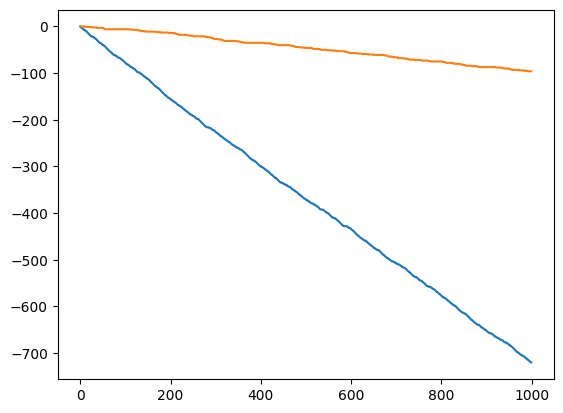

In [7]:
# player1 cooperates, player2 defects
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
print(f"Score [player1, player2]:{np.sum(arr, axis=0)}")
plt.plot(arr.cumsum(axis=0))
plt.show()

In [14]:
## agent which always forages
class AlwaysForage(BasePolicy):
    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        logits[:, 1] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

## agent which always attacks
class AlwaysAttack(BasePolicy):
    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        logits[:, 0] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

## random agent
class RandomAgent(BasePolicy):
    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        logits[:, np.random.choice([0, 1])] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

In [20]:
# Step 2: Wrap the environment for Tianshou interfacing
vec_env = parallel_to_aec(env)
vec_env = PettingZooEnv(vec_env)

# Step 3: Define policies for each agent
## learning agent
net = Net(
    state_shape=vec_env.observation_space.shape,
    action_shape=vec_env.action_space.n,
    hidden_sizes=[128, 128],
    device="cuda",
).to("cuda")
optim = Adam(net.parameters(), lr=1e-4)
agent_learn = DQNPolicy(
    model=net,
    optim=optim,
    discount_factor=0.9,
    estimation_step=3,
    target_update_freq=320,
)

policies = MultiAgentPolicyManager([AlwaysForage(), agent_learn], vec_env)

vec_env = DummyVectorEnv([lambda: vec_env])

# Step 4: Collector setup
collector = Collector(
    policies,
    vec_env,
    VectorReplayBuffer(20_000, len(vec_env)),
    exploration_noise=True,
)

Score [player1, player2]:[-271. -277.]


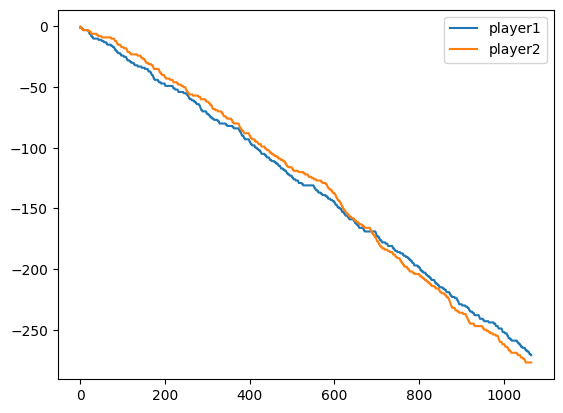

In [21]:
result = collector.collect(n_step=64*100)
arr = result["rews"]
print(f"Score [player1, player2]:{np.sum(arr, axis=0)}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

In [22]:


# # Step 5: Construct the Collector, which interfaces the policies with the vectorised environment
# collector = Collector(policies, vec_env)

# # Step 6: Execute the environment with the agents playing for 1 episode, and render a frame every 0.1 seconds
# result = collector.collect(n_episode=1000, render=0.00001)

# arr = result["rews"]
# print(f"Score [player1, player2]:{np.sum(arr, axis=0)}")
# plt.plot(arr.cumsum(axis=0))
# plt.show()